## Sentiment Analysis of Restaurant Reviews

In [1]:
import warnings
import pandas as pd
warnings.simplefilter("ignore")

### Data Preprocessing

In [2]:
test = pd.read_csv("test.csv")

In [3]:
data = pd.read_csv("Reviews.csv")[:10000][["Text", "Score"]]

In [4]:
for i, d in enumerate(data["Score"]):
    if d >= 4:
        data["Score"][i] = 1
    else:
        data["Score"][i] = 0

In [5]:
text_list = []
text_list2 = []

for d in data["Text"]:
    text_list.append(d)
    
for d in test["Text"]:
    text_list2.append(d)

### Tokenization

In [6]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [7]:
vocab_size = 3800
token = Tokenizer(num_words=vocab_size) 
token.fit_on_texts(text_list)

In [8]:
# token.word_index

In [9]:
x_train_seq = token.texts_to_sequences(text_list)
x_test_seq = token.texts_to_sequences(text_list2)

In [10]:
maxlen = 380
x_train = sequence.pad_sequences(x_train_seq, maxlen=maxlen)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=maxlen)

In [11]:
y_train = data["Score"]

### CNN Modeling

In [12]:
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input, Dropout

In [13]:
x_train.shape

(10000, 380)

In [14]:
embedding_dim = 32

model_CNN = Sequential()
model_CNN.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_CNN.add(Dropout(0.7))
model_CNN.add(layers.Conv1D(128, 5, activation='relu'))
model_CNN.add(layers.GlobalMaxPooling1D())
model_CNN.add(Dropout(0.7))
model_CNN.add(layers.Dense(10, activation='relu'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 380, 32)           121600    
                                                                 
 dropout (Dropout)           (None, 380, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 376, 128)          20608     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                        

In [16]:
history = model_CNN.fit(x_train, y_train,
                        epochs=10,
                        verbose=2,
                        validation_split=0.2,
                        batch_size=100)

Epoch 1/10
80/80 - 4s - loss: 0.5666 - accuracy: 0.7517 - val_loss: 0.5949 - val_accuracy: 0.7440 - 4s/epoch - 47ms/step
Epoch 2/10
80/80 - 3s - loss: 0.5410 - accuracy: 0.7660 - val_loss: 0.5868 - val_accuracy: 0.7440 - 3s/epoch - 41ms/step
Epoch 3/10
80/80 - 3s - loss: 0.5189 - accuracy: 0.7673 - val_loss: 0.5720 - val_accuracy: 0.7425 - 3s/epoch - 41ms/step
Epoch 4/10
80/80 - 3s - loss: 0.4911 - accuracy: 0.7648 - val_loss: 0.5342 - val_accuracy: 0.7575 - 3s/epoch - 42ms/step
Epoch 5/10
80/80 - 3s - loss: 0.4623 - accuracy: 0.7785 - val_loss: 0.4795 - val_accuracy: 0.7725 - 3s/epoch - 41ms/step
Epoch 6/10
80/80 - 3s - loss: 0.4142 - accuracy: 0.8064 - val_loss: 0.4433 - val_accuracy: 0.7880 - 3s/epoch - 42ms/step
Epoch 7/10
80/80 - 3s - loss: 0.3645 - accuracy: 0.8370 - val_loss: 0.4159 - val_accuracy: 0.8085 - 3s/epoch - 42ms/step
Epoch 8/10
80/80 - 3s - loss: 0.3536 - accuracy: 0.8400 - val_loss: 0.4137 - val_accuracy: 0.8130 - 3s/epoch - 42ms/step
Epoch 9/10
80/80 - 3s - loss: 0.

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.8785


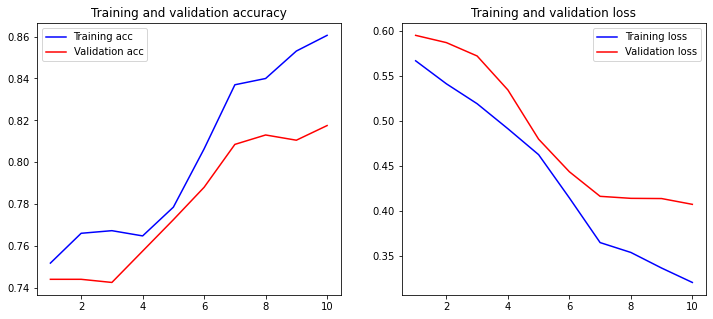

In [19]:
loss, accuracy = model_CNN.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

plot_history(history)

In [20]:
prediction = model_CNN.predict(x_test)

pred_list = []

for p in prediction:
    if p >= 0.8:
        pred_list.append(1)
    else:
        pred_list.append(0)

### LSTM

In [21]:
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation, Flatten

modelLSTM = Sequential()
modelLSTM.add(Embedding(output_dim=32,  # vector of 32-D
                        input_dim=3800, # length of dictionary
                        input_length=380)) # num. of sentence list

modelLSTM.add(Dropout(0.7))
modelLSTM.add(LSTM(32))     # LSTM with 32 neuron
modelLSTM.add(Dense(units=256,activation='relu'))  # hidden layer with 256 neuron
modelLSTM.add(Dropout(0.7)) # to avoid overfitting
modelLSTM.add(Dense(units=1,activation='sigmoid')) # output layer

In [22]:
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 380, 32)           121600    
                                                                 
 dropout_2 (Dropout)         (None, 380, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 138,625
Trainable params: 138,625
Non-tr

In [23]:
modelLSTM.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

train_history = modelLSTM.fit(x_train, y_train,
                              epochs=10, 
                              batch_size=100,
                              verbose=2,
                              validation_split=0.2)

Epoch 1/10
80/80 - 10s - loss: 0.5701 - accuracy: 0.7616 - val_loss: 0.5391 - val_accuracy: 0.7440 - 10s/epoch - 120ms/step
Epoch 2/10
80/80 - 8s - loss: 0.4298 - accuracy: 0.7970 - val_loss: 0.4254 - val_accuracy: 0.8025 - 8s/epoch - 105ms/step
Epoch 3/10
80/80 - 10s - loss: 0.3146 - accuracy: 0.8634 - val_loss: 0.3858 - val_accuracy: 0.8345 - 10s/epoch - 124ms/step
Epoch 4/10
80/80 - 11s - loss: 0.2649 - accuracy: 0.8901 - val_loss: 0.3837 - val_accuracy: 0.8385 - 11s/epoch - 133ms/step
Epoch 5/10
80/80 - 11s - loss: 0.2454 - accuracy: 0.9015 - val_loss: 0.4164 - val_accuracy: 0.8465 - 11s/epoch - 131ms/step
Epoch 6/10
80/80 - 11s - loss: 0.2124 - accuracy: 0.9141 - val_loss: 0.4654 - val_accuracy: 0.8395 - 11s/epoch - 133ms/step
Epoch 7/10
80/80 - 11s - loss: 0.1997 - accuracy: 0.9231 - val_loss: 0.4577 - val_accuracy: 0.8395 - 11s/epoch - 132ms/step
Epoch 8/10
80/80 - 11s - loss: 0.1834 - accuracy: 0.9294 - val_loss: 0.4195 - val_accuracy: 0.8450 - 11s/epoch - 131ms/step
Epoch 9/10

Training Accuracy: 0.9362


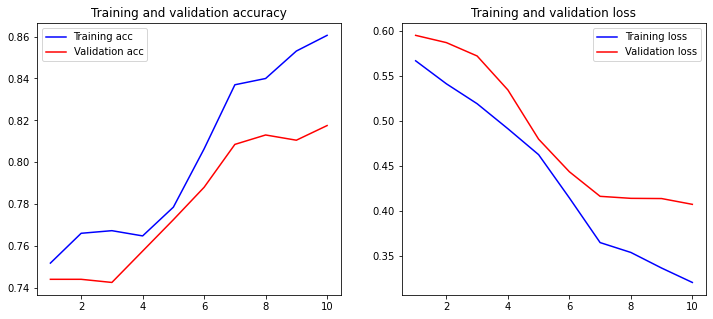

In [24]:
loss, accuracy = modelLSTM.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

plot_history(history)

In [25]:
prediction = modelLSTM.predict(x_test)

pred_list = []

for p in prediction:
    if p >= 0.8:
        pred_list.append(1)
    else:
        pred_list.append(0)